In [1]:
cd /g/data/jk72/deg581/apom/ana/notebooks

/g/data/jk72/deg581/apom/ana/notebooks


In [2]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.ticker as mticker

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import repackage
repackage.add('../../')
repackage.add('../')

'/jobfs/130727389.gadi-pbs'

In [3]:
# Suite for Analysis - Overview

# script needs to:
# load 1-5 variables from multiple files
# run some calculation and concatenate together
# make some plots

In [5]:

def inpolygon(xq, yq, xv, yv):
    from matplotlib import path
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)

# map u,v to rho points
def ROMSmetricsAndGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    print('making pm/pn metrics')
    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)
    print('making dx/dy')
    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

#     ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
#     ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
#     ds['dz_u'] = grid.interp(ds.dz, 'X')
#     ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
#     ds['dz_v'] = grid.interp(ds.dz, 'Y')
#     ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        # ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds,grid



def add_zeros_to_4(date):
    if date<10:
        to_add = '000'
    elif date>9 & date<100:
        to_add = '00'
    elif date>99 & date < 1000:
        to_add = '0'
    else: 
        to_add = ''
    return to_add

def generateFileList(FilePath,prefix,datelist):
    filelist=[FilePath+prefix+add_zeros_to_4(datelist[0])+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=FilePath+prefix+add_zeros_to_4(dates)+str(dates)+'.nc'
        filelist.append(filenameToAppend)
    return filelist

### first load from average files

In [7]:
grd = xr.open_dataset('/g/data/jk72/deg581/vanderford-setup/data/proc/vand_2km_v5_lb2_grd.nc')


['/g/data/jk72/deg581/vanom/mdl/vanderford_v5_lb2/roms_his_0010.nc']
0.418906436 G
0.415037728 G


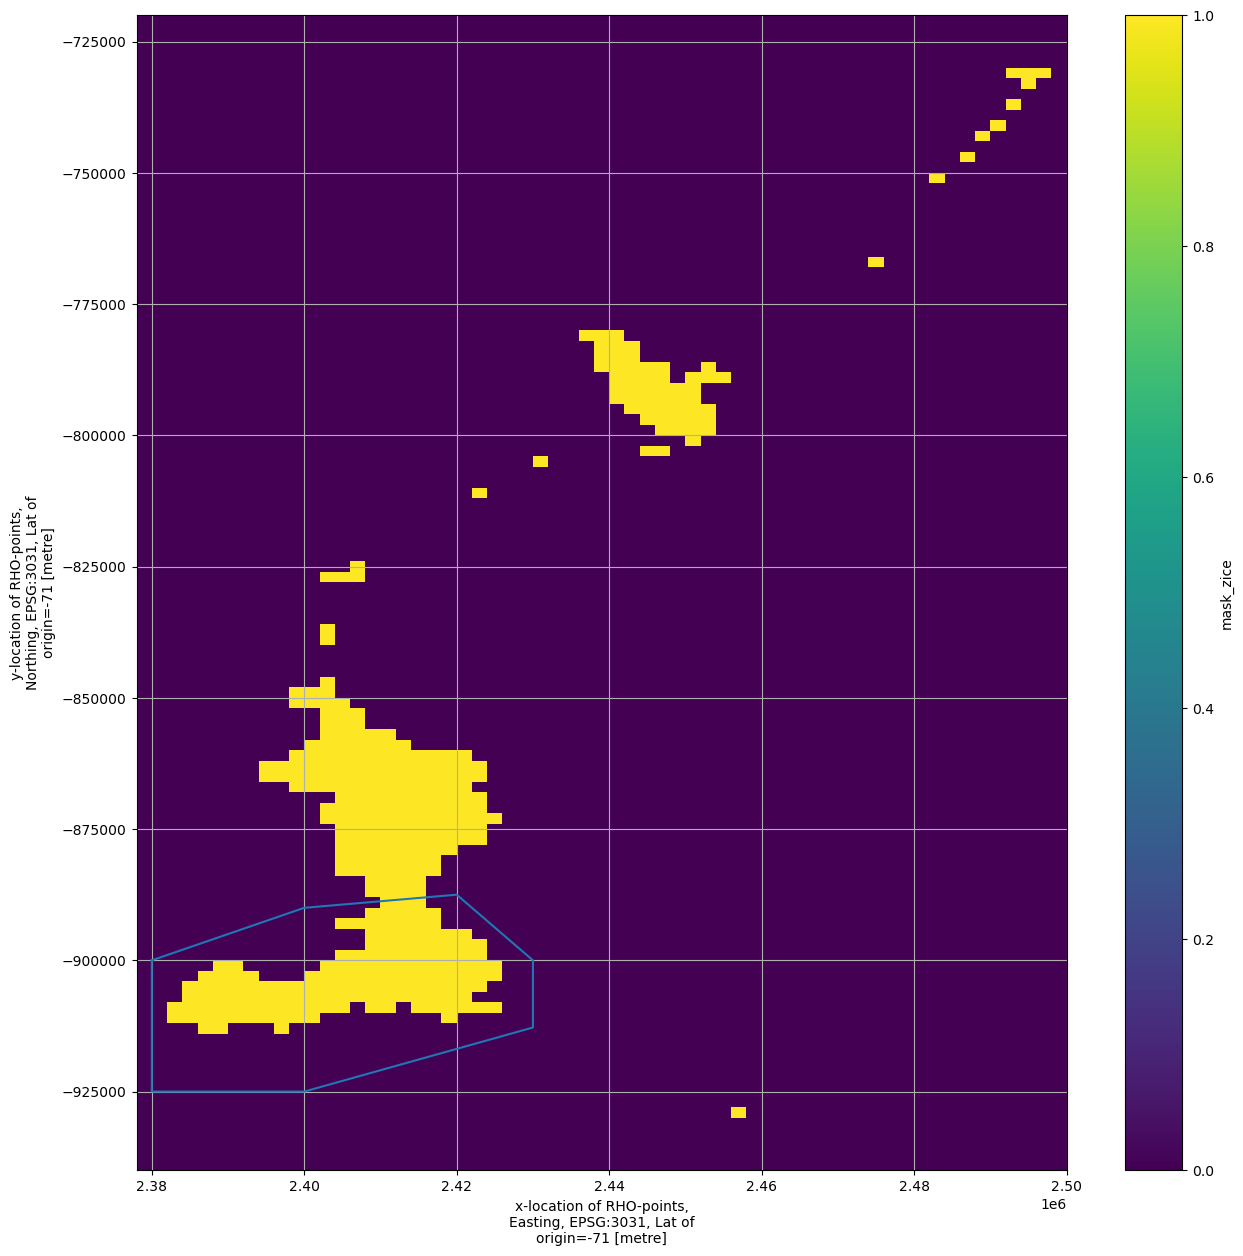

making vertical coordinates
making pm/pn metrics
making dx/dy
correctly mask melt
mapping u/v to u/v rho


In [8]:


FilePath='/g/data/jk72/deg581/vanom/mdl/vanderford_v5_lb2/' # Truth file settings
prefix='roms_his_'
timeRange = [10, 11]
datelist = np.array(range(timeRange[0],timeRange[1],1))


fl=generateFileList(FilePath,prefix,datelist)
print(fl)

# ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds.nbytes/1e9,'G')

ds = ds.drop_vars(['sustr','svstr','ssflux','shflux'])
ds['my'] = ds.m*(60*60*24*365)
print(ds.nbytes/1e9,'G')
ds

ds = ds.assign_coords({"x_rho": grd.x_rho})
ds = ds.assign_coords({"y_rho": grd.y_rho})
ds = ds.assign_coords({"lon_rho": grd.lon_rho})
ds = ds.assign_coords({"lat_rho": grd.lat_rho})

# ds['hc'] = grd.hc
# ds['s_w']=grd.s_w
# ds['s_rho']=grd.s_rho
# ds['Cs_w']=grd.Cs_w
# ds['Cs_r']=grd.Cs_r


# ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

ds['mask_zice'] = (ds.mask_rho.where(ds.zice<0)==1) # make a logic mask for ice

ds['mask_openocean'] = ds.mask_rho*(ds.mask_zice==0)

ds['mask_openoceanNaN'] = ds.mask_openocean.where(ds.mask_openocean)

ds['mask_rhoNaN'] = ds.mask_rho.where(ds.mask_rho)

ds['mask_ziceNaN'] = ds.mask_zice.where(ds.mask_zice)

# make masks

plt.figure(figsize=(15,15))
ds.mask_zice.plot(x='x_rho',y='y_rho')
plt.grid()
poly_shelf = np.array([
    [2.38e6,-900000],
    [2.38e6,-925000],
    [2.4e6,-925000],
    [2.43e6,-912800],
    [2.43e6,-900000],
    [2.42e6,-887500],
	[2.40e6,-890000],
    [2.38e6,-900000]])
plt.plot(poly_shelf[:,0],poly_shelf[:,1])
plt.show()


mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])

ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# ds.mask_zice_roi.plot()
roi_label1 = 'vanderford'
ds.mask_zice_roi.attrs['long_name']=roi_label1

# set any grid data here.

weights_area = (1/ds.pm)*(1/ds.pn)
weights_area.name = "weights"

print('making vertical coordinates')
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = (ds.zice) + ((ds.zice) + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * ((ds.zice) + ds.h) + (ds.zice)
    
ds.coords['z_w0'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho0'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')

# ds['dz'] = (('ocean_time','s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w,axis=1))

ds, grid = ROMSmetricsAndGrid(ds)

print('correctly mask melt')
ds['m'] = ds.m*ds.mask_ziceNaN
ds['my'] = ds.m*(60*60*24*365)


print('mapping u/v to u/v rho')
ds['u_rho'] = grid.interp(ds.u,'X')
ds['v_rho'] = grid.interp(ds.v,'Y')

ds_LB = ds

ds.close()

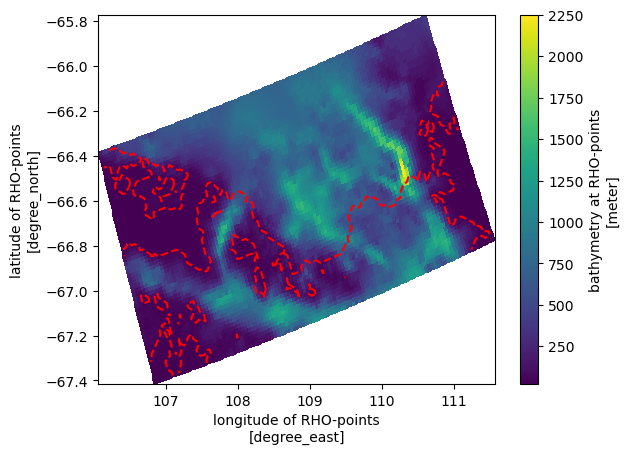

In [19]:
ds_LB.h.plot(x='lon_rho',y='lat_rho')
ds_LB.zice.plot.contour(x='lon_rho',y='lat_rho',colors='r',levels=[-1,0])

In [9]:
### load oras5 sst

ds_oras5 = xr.open_mfdataset('/g/data/gi0/iomp/oras5/sosstsst_control_monthly_highres_2D_2007*')

# # shift lon line
# oLon = ds_oras5.nav_lon.values
# oLon[oLon<0]+=360
# # plt.pcolormesh(oLon)
# # plt.colorbar()
# ds_oras5['lon']=(('y','x'),oLon)
# ds_oras5 = ds_oras5.assign_coords({"lon": ds_oras5.lon})


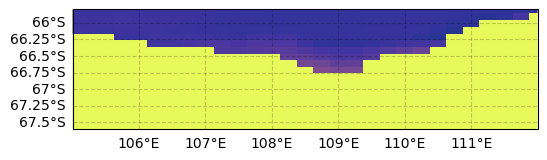

In [22]:
import cartopy.crs as ccrs

fig = plt.figure(figsize=(6,6))

# setup an plotting axis. Missing points will be gray. Shift the center of the map to Pacific.
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([105, 112, -67.6, -65.8])
# Plot ocean depth. Note: generally best to transform to PlateCarre regardless of the map projection
ax.pcolormesh(ds_oras5.nav_lon, ds_oras5.nav_lat, ds_oras5.sosstsst.isel(time_counter=11), transform=ccrs.PlateCarree(), vmin=-3,vmax=3,cmap='cmo.thermal')
gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
# gl.xlocator = mticker.FixedLocator(np.arange(50,100))
# gl.ylocator = mticker.FixedLocator(np.arange(-90,-40))




In [13]:
ds_oras5

<xarray.Dataset>
Dimensions:       (y: 1021, x: 1442, time_counter: 12)
Coordinates:
    nav_lat       (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 2007-01-16 ... 2007-12-16
Dimensions without coordinates: y, x
Data variables:
    sosstsst      (time_counter, y, x) float32 dask.array<chunksize=(1, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.4
    NCO:          netCDF Operators version 4.9.2 (Homepage = http://nco.sf.ne...
    title:        Monthly mean 2D Sea Surface fields
    source:       ORAS5 - backward extension (ECMWF)
    institution:  European Centre for Medium-Range Weather Forecasts (ECMWF) ...
    reference:    https://www.ecmwf.int/en/research/climate-reanalysis/ocean-...

In [25]:
ds_LB

<xarray.Dataset>
Dimensions:            (tracer: 2, boundary: 4, s_rho: 25, s_w: 26,
                        eta_rho: 110, xi_rho: 61, xi_u: 60, eta_v: 109,
                        ocean_time: 73)
Coordinates: (12/15)
  * s_rho              (s_rho) float64 -0.98 -0.94 -0.9 ... -0.1 -0.06 -0.02
  * s_w                (s_w) float64 -1.0 -0.96 -0.92 -0.88 ... -0.08 -0.04 0.0
    x_rho              (eta_rho, xi_rho) float64 2.379e+06 ... 2.499e+06
    y_rho              (eta_rho, xi_rho) float64 -9.39e+05 ... -7.21e+05
    x_u                (eta_rho, xi_u) float64 dask.array<chunksize=(110, 60), meta=np.ndarray>
    y_u                (eta_rho, xi_u) float64 dask.array<chunksize=(110, 60), meta=np.ndarray>
    ...                 ...
    y_psi              (eta_v, xi_u) float64 dask.array<chunksize=(109, 60), meta=np.ndarray>
  * ocean_time         (ocean_time) datetime64[ns] 2016-01-04 ... 2016-12-29
    lon_rho            (eta_rho, xi_rho) float64 111.5 111.5 ... 106.1 106.1
    lat_rho            (eta_rho, xi_rho) float64 -66.77 -66.75 ... -66.41 -66.39
    z_w0               (s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(26, 110, 61), meta=np.ndarray>
    z_rho0             (s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(25, 110, 61), meta=np.ndarray>
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/109)
    ntimes             int32 ...
    ndtfast            int32 ...
    dt                 float64 ...
    dtfast             float64 ...
    dstart             datetime64[ns] ...
    nHIS               int32 ...
    ...                 ...
    dy_u               (eta_rho, xi_u) float64 dask.array<chunksize=(110, 60), meta=np.ndarray>
    dy_v               (eta_v, xi_rho) float64 dask.array<chunksize=(109, 61), meta=np.ndarray>
    dy_psi             (eta_v, xi_u) float64 dask.array<chunksize=(109, 60), meta=np.ndarray>
    dA                 (eta_rho, xi_rho) float64 dask.array<chunksize=(110, 61), meta=np.ndarray>
    u_rho              (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 25, 110, 61), meta=np.ndarray>
    v_rho              (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 25, 110, 61), meta=np.ndarray>
Attributes: (12/34)
    file:              roms_his_0010.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             Vanderford Ice Shelf-ocean Application
    var_info:          ROMS/External/varinfo.yaml
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            012x016
    history:           ROMS/TOMS, Version 4.1, Friday - December 13, 2024 -  ...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       VANDERFORD, ANA_BSFLUX, ANA_BTFLUX, ANA_INITIAL, ANA_S...

In [28]:
ds_LB.isel(ocean_time=-1).ocean_time

<xarray.DataArray 'ocean_time' ()>
array('2016-12-29T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    ocean_time  datetime64[ns] 2016-12-29
Attributes:
    standard_name:  time
    long_name:      time since initialization
    field:          time

<Figure size 640x480 with 0 Axes>

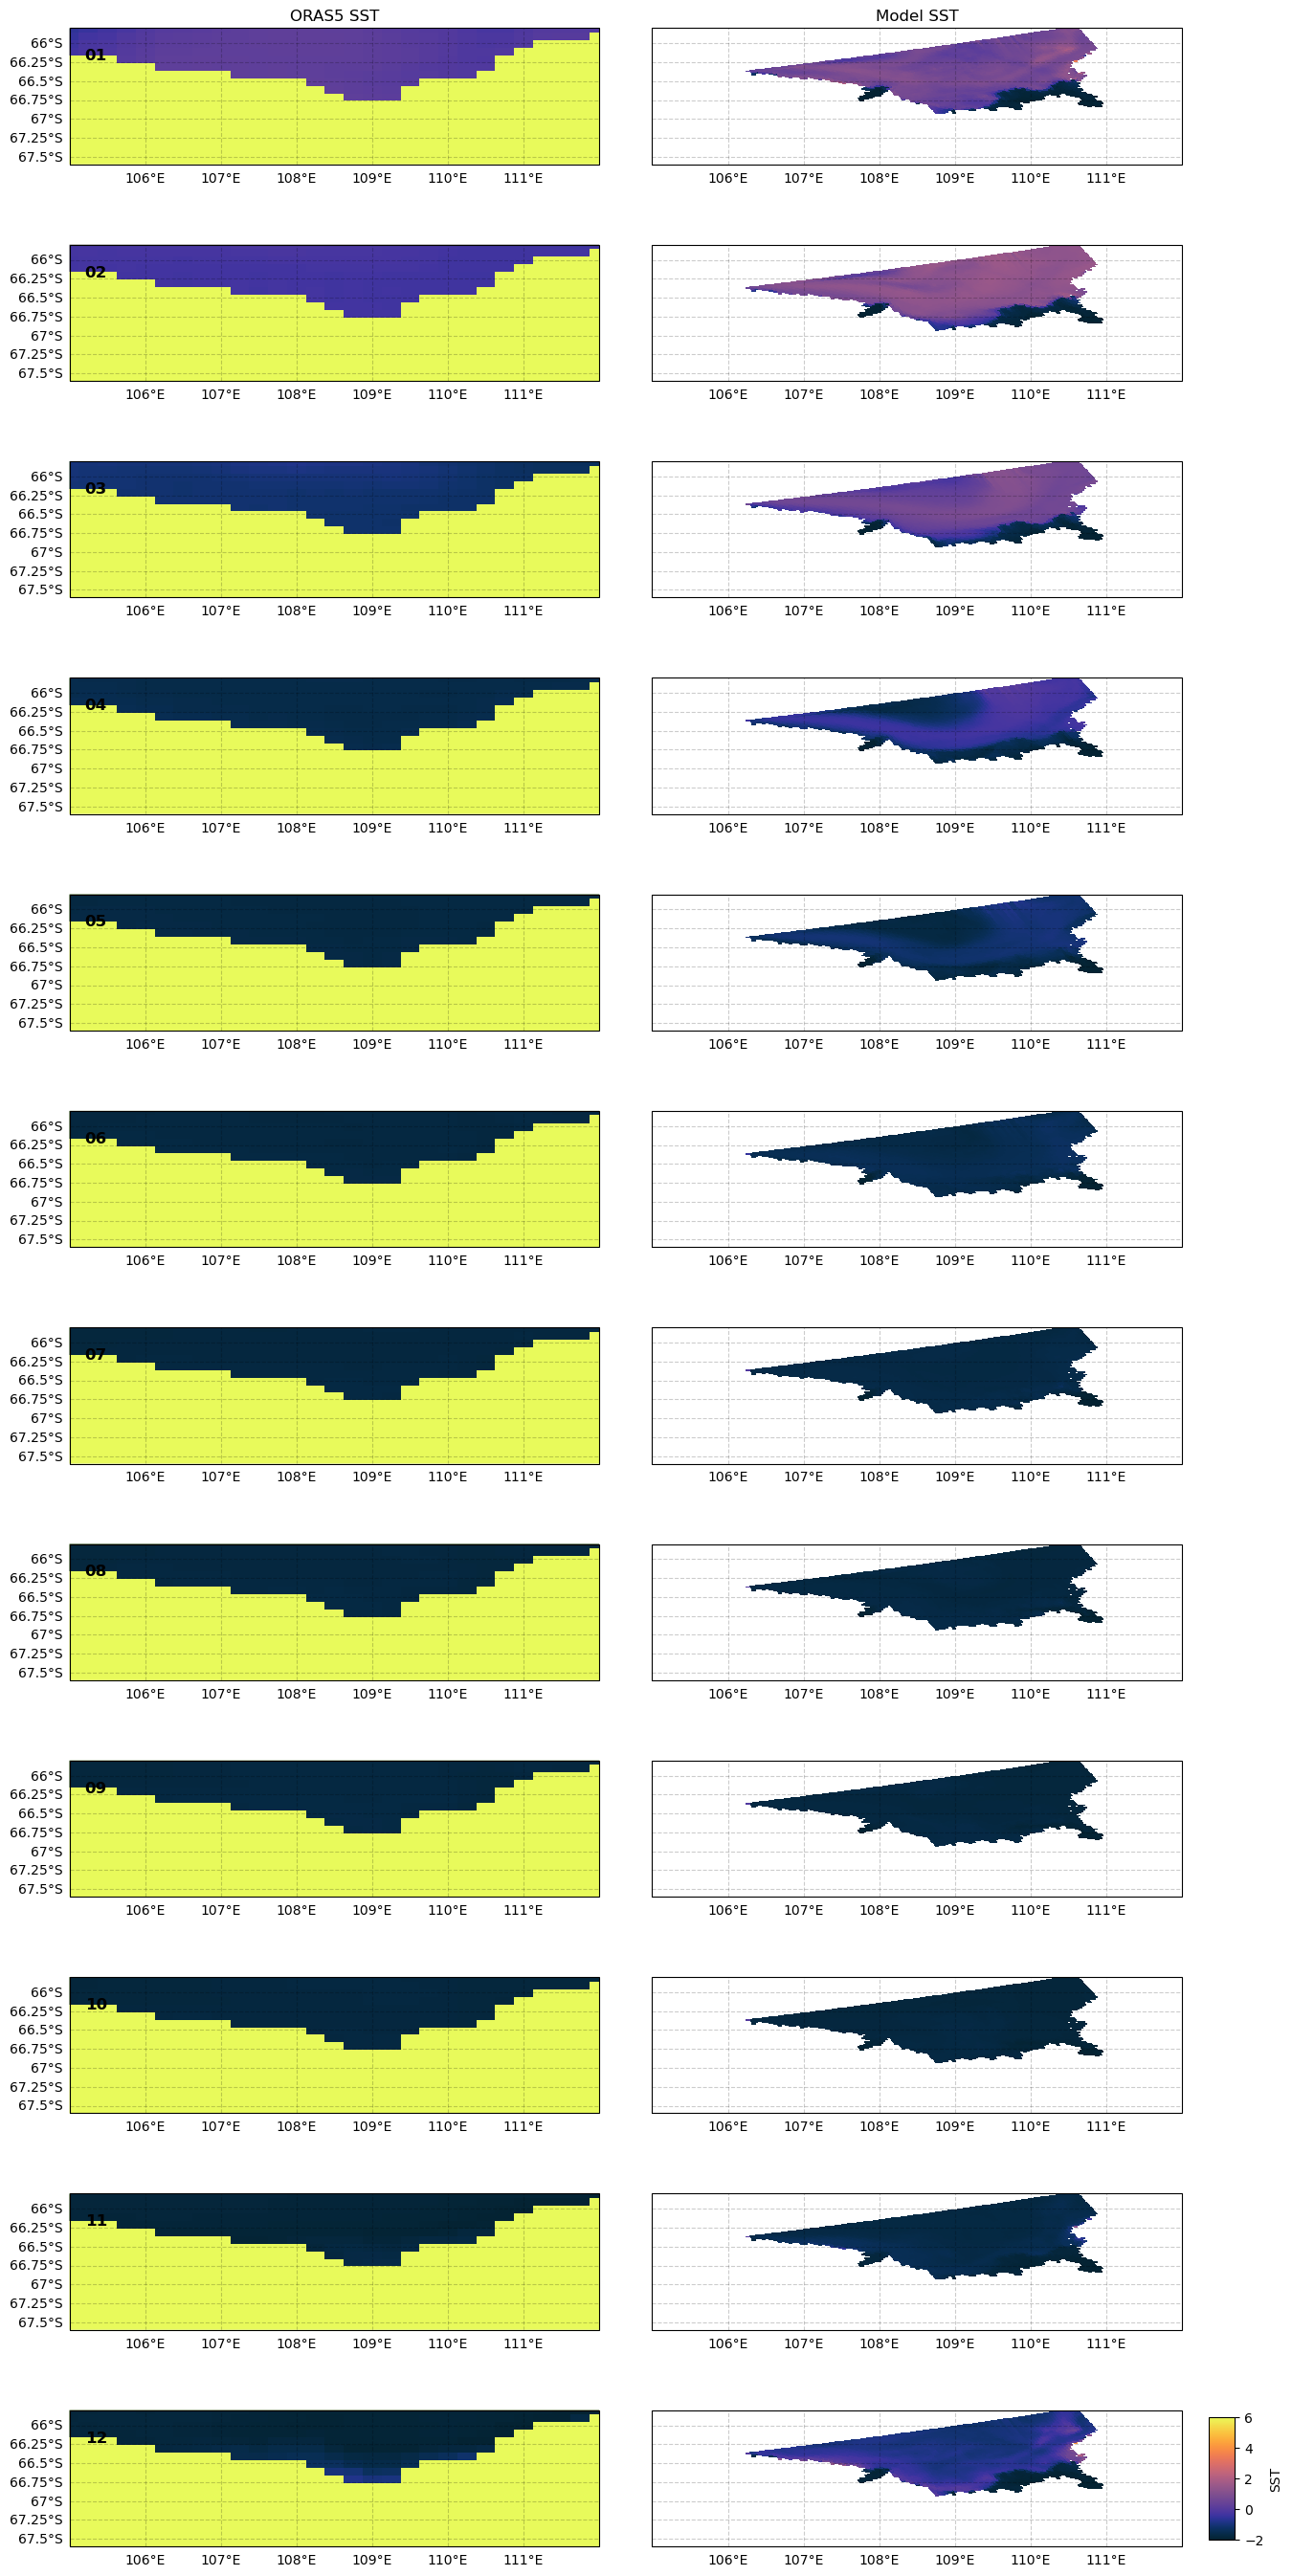

In [31]:
#for 1 month (jan), plot both maps


gs = gridspec.GridSpec(nrows=12,ncols=2,wspace=0.1, hspace=0.1)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,35])
ax = None


mon_list = range(1,13,1)
ii=0
for mon in mon_list:
    
    yrstr1='2016-'
    
    if mon<9:
        monstr = '0'+str(mon)
        monstr1= '0'+str(mon+1)
    elif mon==9:
        monstr = '0'+str(mon)
        monstr1= str(mon+1)
    else:
        monstr = str(mon)
        monstr1= str(mon+1)
    
    if mon==12:
        monstr1 = '01'
        yrstr1 = '2017-'


    
    ax = fig.add_subplot(gs[mon-1,0],projection=ccrs.PlateCarree())
    ax.set_extent([105, 112, -67, -65.6])
    # Plot ocean depth. Note: generally best to transform to PlateCarre regardless of the map projection
    ax.pcolormesh(ds_oras5.nav_lon, ds_oras5.nav_lat, ds_oras5.sosstsst.isel(time_counter=mon-1), transform=ccrs.PlateCarree(), vmin=-2,vmax=6,cmap='cmo.thermal')
    # co=ax.contour(ds_oras5.nav_lon, ds_oras5.nav_lat, ds_oras5.sosstsst.isel(time_counter=mon-1), transform=ccrs.PlateCarree(), levels=np.arange(-10,12,2),colors='k',linewidths=1)
    gl = ax.gridlines(draw_labels=True,
                         color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    # gl.xlocator = mticker.FixedLocator(np.arange(50,100))
    # gl.ylocator = mticker.FixedLocator(np.arange(-90,-40))
    ax.text(0.05, .8, monstr,fontsize=12, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
    if mon==1:
        ax.set_title('ORAS5 SST')
    
    ax = fig.add_subplot(gs[mon-1,1],projection=ccrs.PlateCarree())
    ax.set_extent([105, 112, -67, -65.6])
    # Plot ocean depth. Note: generally best to transform to PlateCarre regardless of the map projection
    im=ax.pcolormesh(ds_LB.lon_rho,ds_LB.lat_rho,ds_LB.temp.isel(s_rho=-1).sel(ocean_time=slice('2016-'+monstr+'-01',yrstr1+monstr1+'-01')).mean(dim='ocean_time'), transform=ccrs.PlateCarree(), vmin=-2,vmax=6,cmap='cmo.thermal')
    # co=ax.contour(ds.lon_rho,ds.lat_rho,ds.temp.isel(s_rho=-1).sel(ocean_time=slice('2027-'+monstr+'-01',yrstr1+monstr1+'-01')).mean(dim='ocean_time'), transform=ccrs.PlateCarree(), levels=np.arange(-10,12,2),colors='k',linewidths=1)
    gl = ax.gridlines(draw_labels=True,
                         color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    # gl.xlocator = mticker.FixedLocator(np.arange(50,100))
    # gl.ylocator = mticker.FixedLocator(np.arange(-90,-40))
    if mon==1:
        ax.set_title('Model SST')    


cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="90%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.05,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('SST')


In [35]:
isomip = xr.open_dataset('/g/data/jk72/deg581/scratch_m68/ISOMIP_PLUS_Ocean1/ocean_his.nc')


In [ ]:
isomip

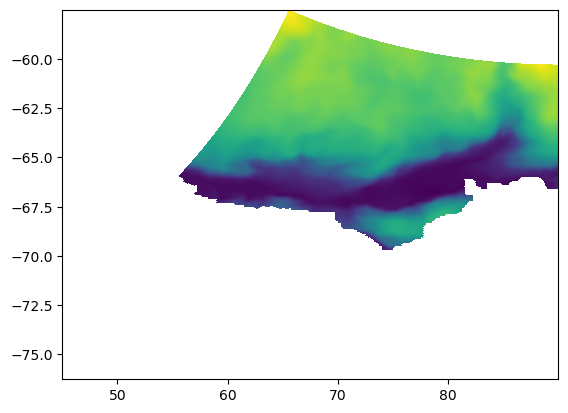

In [37]:
# for ii in range(0,12):
#     oras5[ii,:,:]=griddata((ds_oras5.nav_lon.values.flatten(),ds_oras5.nav_lat.values.flatten()),ds_oras5.sosstsst.isel(time_counter=0).values.flatten(),(ds.lon_rho,ds.lat_rho))

<Figure size 640x480 with 0 Axes>

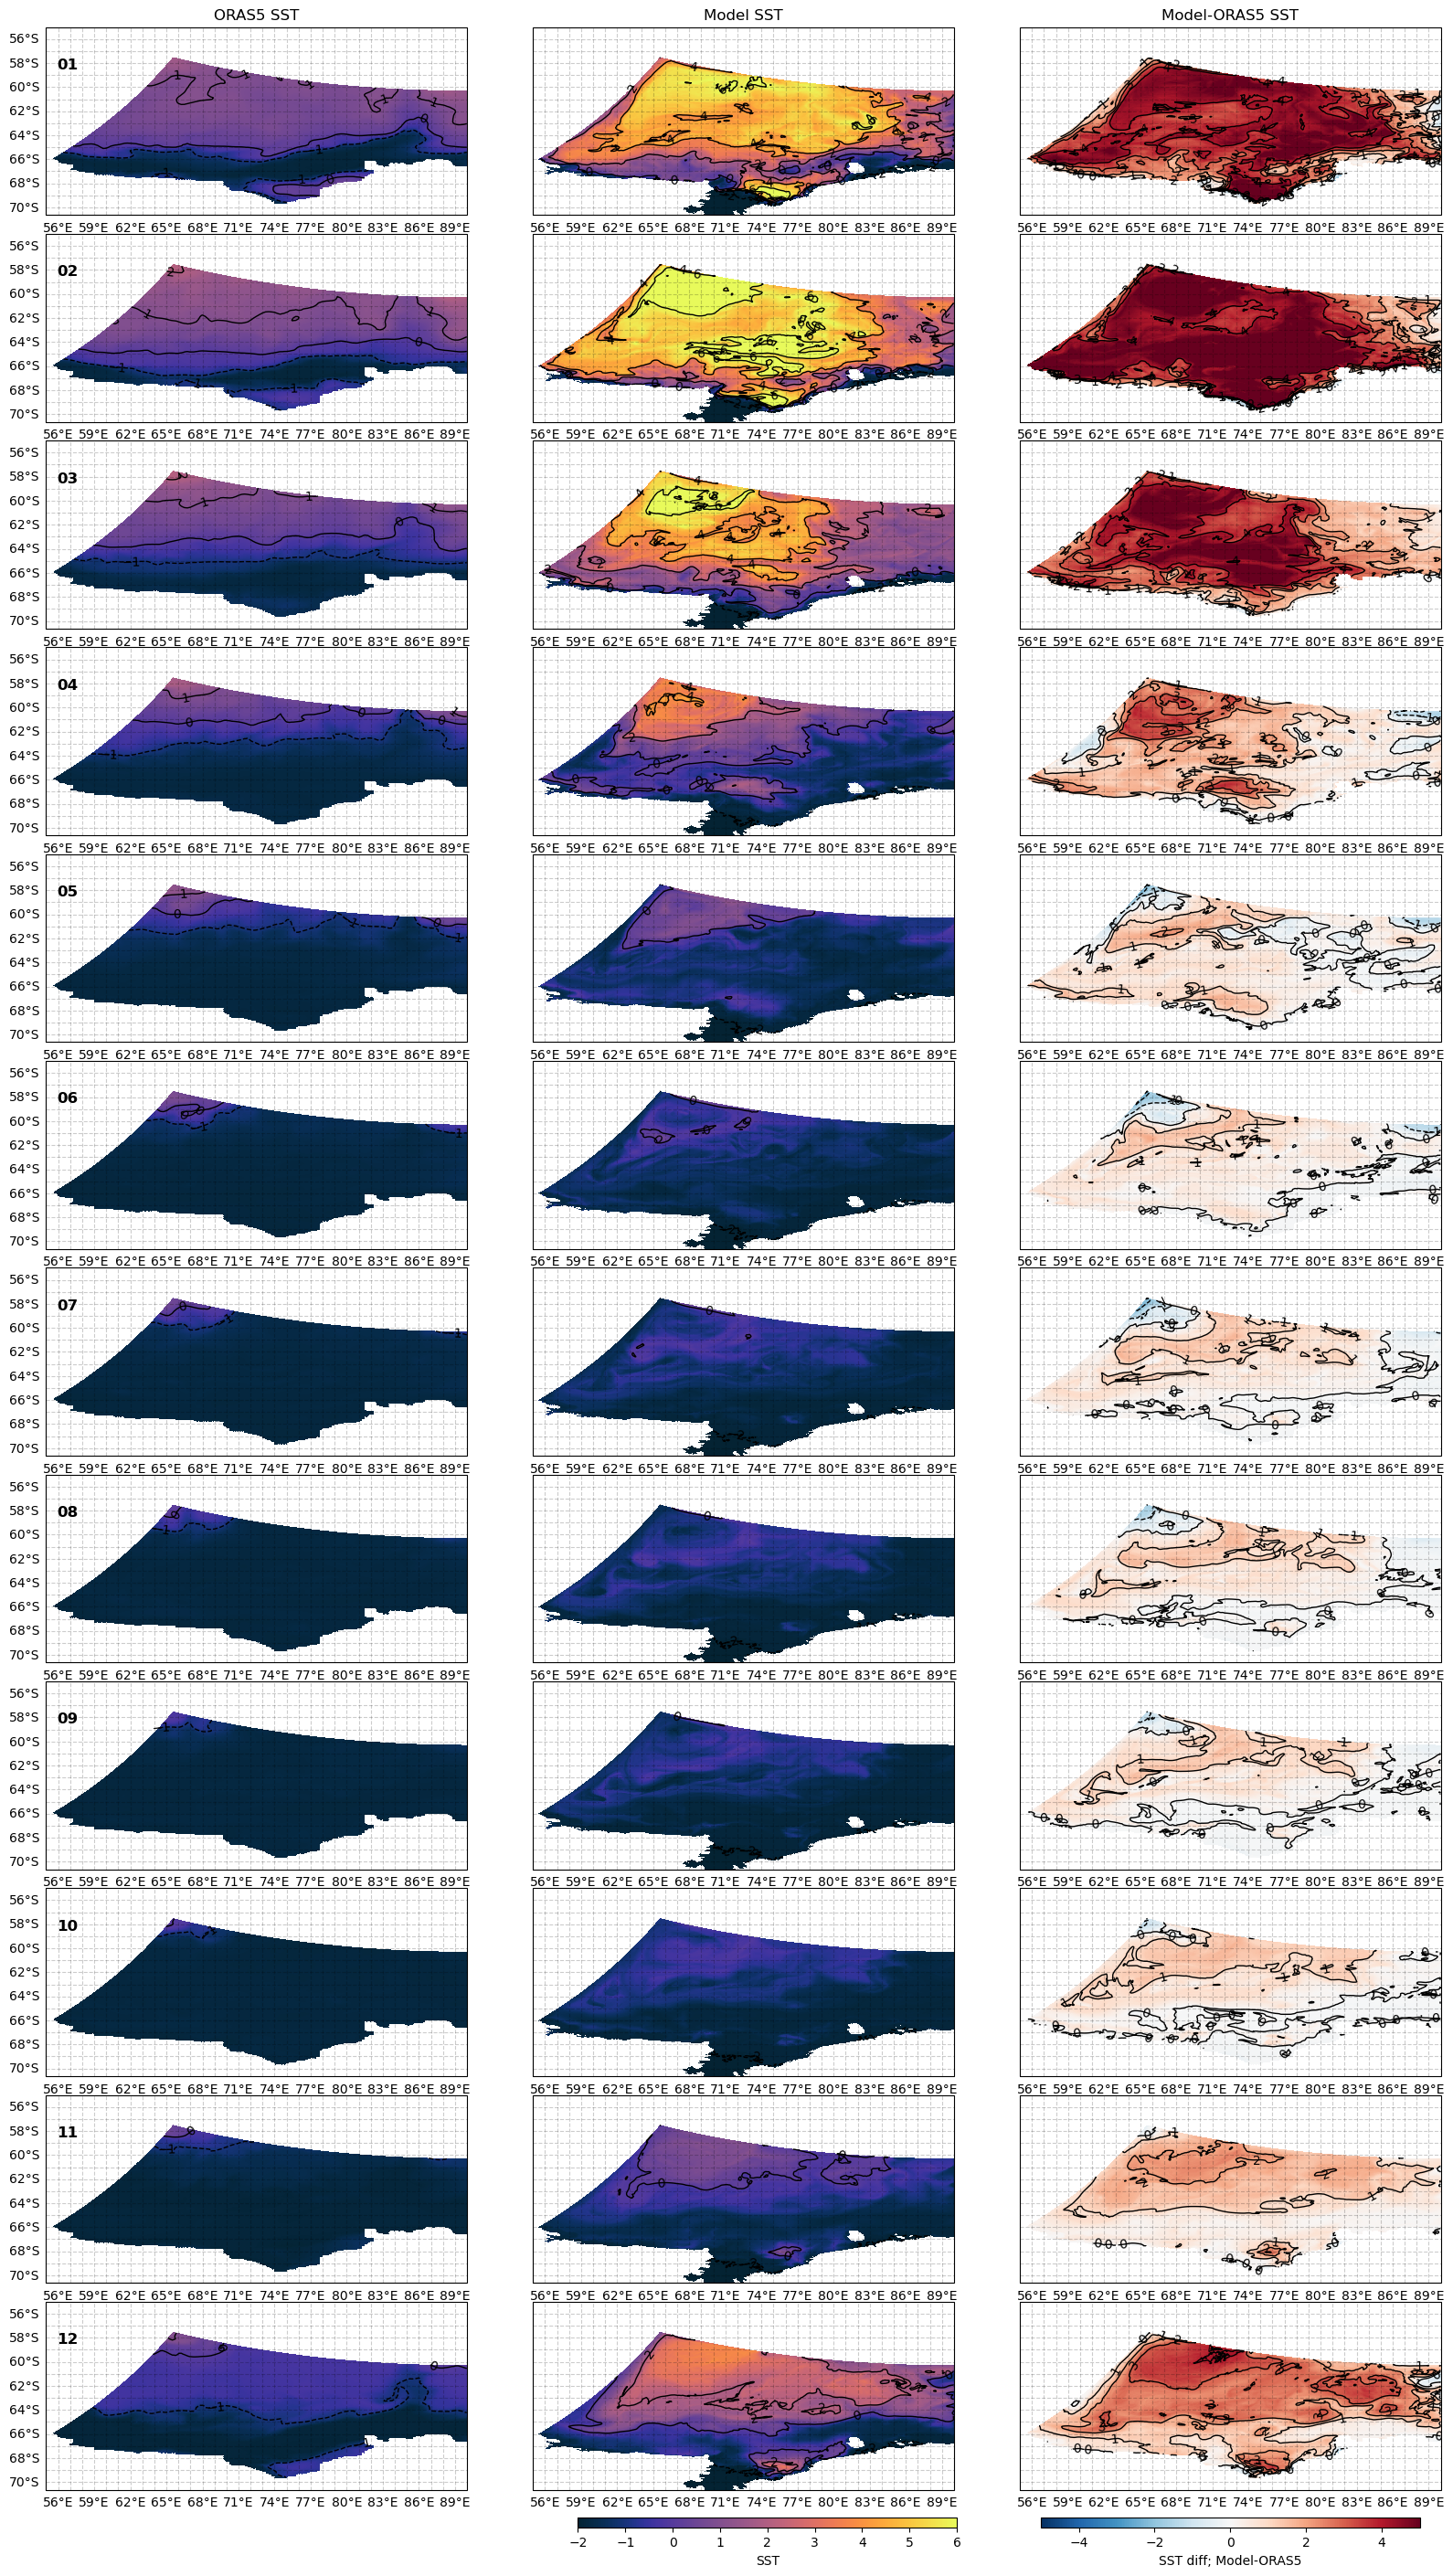

In [40]:
#for 1 month (jan), plot both maps


gs = gridspec.GridSpec(nrows=12,ncols=3,wspace=0.1, hspace=0.1)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,35])
ax = None


mon_list = range(1,13,1)
ii=0
for mon in mon_list:
    
    oras5_i = griddata((ds_oras5.nav_lon.values.flatten(),ds_oras5.nav_lat.values.flatten()),ds_oras5.sosstsst.isel(time_counter=mon-1).values.flatten(),(ds.lon_rho,ds.lat_rho))
    
    yrstr1='2027-'
    
    if mon<9:
        monstr = '0'+str(mon)
        monstr1= '0'+str(mon+1)
    elif mon==9:
        monstr = '0'+str(mon)
        monstr1= str(mon+1)
    else:
        monstr = str(mon)
        monstr1= str(mon+1)
    
    if mon==12:
        monstr1 = '01'
        yrstr1 = '2028-'

        
    ax = fig.add_subplot(gs[mon-1,0],projection=ccrs.PlateCarree())
    ax.set_extent([55, 90, -70, -55])
    # Plot ocean depth. Note: generally best to transform to PlateCarre regardless of the map projection
    im=ax.pcolormesh(ds.lon_rho,ds.lat_rho,oras5_i, transform=ccrs.PlateCarree(), vmin=-2,vmax=6,cmap='cmo.thermal')
    co=ax.contour(ds.lon_rho,ds.lat_rho,oras5_i, transform=ccrs.PlateCarree(), levels=np.arange(-2,7,1),colors='k',linewidths=1)
    ax.clabel(co, inline=1)
    # co=ax.contour(ds_oras5.nav_lon, ds_oras5.nav_lat, ds_oras5.sosstsst.isel(time_counter=mon-1), transform=ccrs.PlateCarree(), levels=np.arange(-10,12,2),colors='k',linewidths=1)
    gl = ax.gridlines(draw_labels=True,
                         color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(50,100))
    gl.ylocator = mticker.FixedLocator(np.arange(-90,-40))
    ax.text(0.05, .8, monstr,fontsize=12, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
    if mon==1:
        ax.set_title('ORAS5 SST')
    
    ax = fig.add_subplot(gs[mon-1,1],projection=ccrs.PlateCarree())
    ax.set_extent([55, 90, -70, -55])
    # Plot ocean depth. Note: generally best to transform to PlateCarre regardless of the map projection
    im=ax.pcolormesh(ds.lon_rho,ds.lat_rho,ds.temp.isel(s_rho=-1).sel(ocean_time=slice('2027-'+monstr+'-01',yrstr1+monstr1+'-01')).mean(dim='ocean_time'), transform=ccrs.PlateCarree(), vmin=-2,vmax=6,cmap='cmo.thermal')
    co=ax.contour(ds.lon_rho,ds.lat_rho,ds.temp.isel(s_rho=-1).sel(ocean_time=slice('2027-'+monstr+'-01',yrstr1+monstr1+'-01')).mean(dim='ocean_time'), transform=ccrs.PlateCarree(), levels=np.arange(-2,7,2),colors='k',linewidths=1)
    ax.clabel(co, inline=1)
    gl = ax.gridlines(draw_labels=True,
                         color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(50,100))
    gl.ylocator = mticker.FixedLocator(np.arange(-90,-40))
    if mon==1:
        ax.set_title('Model SST')    

    ax = fig.add_subplot(gs[mon-1,2],projection=ccrs.PlateCarree())
    ax.set_extent([55, 90, -70, -55])
    # Plot ocean depth. Note: generally best to transform to PlateCarre regardless of the map projection
    im2=ax.pcolormesh(ds.lon_rho,ds.lat_rho,ds.temp.isel(s_rho=-1).sel(ocean_time=slice('2027-'+monstr+'-01',yrstr1+monstr1+'-01')).mean(dim='ocean_time')-oras5_i, transform=ccrs.PlateCarree(), vmin=-5,vmax=5,cmap='RdBu_r')
    co=ax.contour(ds.lon_rho,ds.lat_rho,ds.temp.isel(s_rho=-1).sel(ocean_time=slice('2027-'+monstr+'-01',yrstr1+monstr1+'-01')).mean(dim='ocean_time')-oras5_i, transform=ccrs.PlateCarree(), levels=np.arange(-5,5,1),colors='k',linewidths=1)
    ax.clabel(co, inline=1)
    # co=ax.contour(ds.lon_rho,ds.lat_rho,ds.temp.isel(s_rho=-1).sel(ocean_time=slice('2027-'+monstr+'-01',yrstr1+monstr1+'-01')).mean(dim='ocean_time'), transform=ccrs.PlateCarree(), levels=np.arange(-10,12,2),colors='k',linewidths=1)
    gl = ax.gridlines(draw_labels=True,
                         color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(50,100))
    gl.ylocator = mticker.FixedLocator(np.arange(-90,-40))
    if mon==1:
        ax.set_title('Model-ORAS5 SST')    


cax = inset_axes(ax,
                width="90%",  # width = 10% of parent_bbox width
                height="5%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.05,-.2, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax,orientation='horizontal') 
cbar.set_label('SST diff; Model-ORAS5')


cax = inset_axes(ax,
                width="90%",  # width = 10% of parent_bbox width
                height="5%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(-1.05,-.2, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax,orientation='horizontal') 
cbar.set_label('SST')


<Figure size 640x480 with 0 Axes>

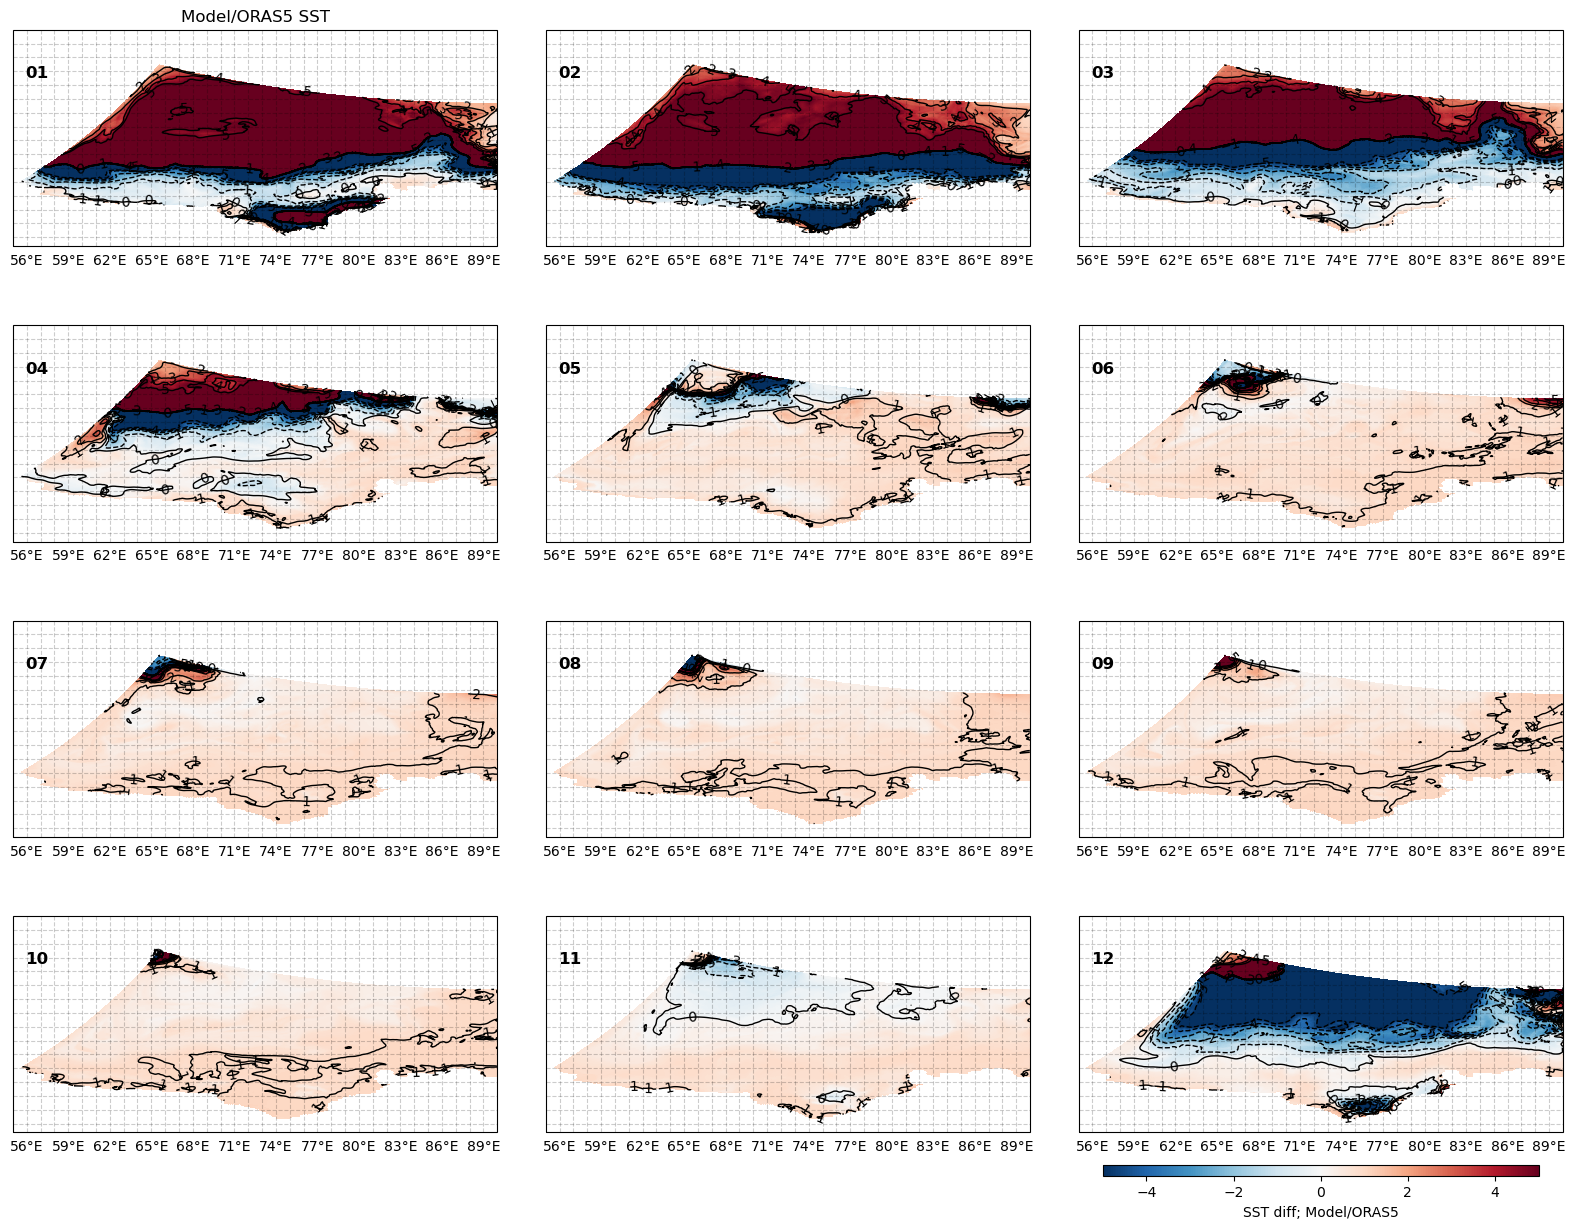

In [43]:
#for 1 month (jan), plot both maps


gs = gridspec.GridSpec(nrows=4,ncols=3,wspace=0.1, hspace=0.1)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,12])
ax = None


mon_list = range(1,13,1)
ii=0
for mon in mon_list:
    
    oras5_i = griddata((ds_oras5.nav_lon.values.flatten(),ds_oras5.nav_lat.values.flatten()),ds_oras5.sosstsst.isel(time_counter=mon-1).values.flatten(),(ds.lon_rho,ds.lat_rho))
    
    yrstr1='2027-'
    
    if mon<9:
        monstr = '0'+str(mon)
        monstr1= '0'+str(mon+1)
    elif mon==9:
        monstr = '0'+str(mon)
        monstr1= str(mon+1)
    else:
        monstr = str(mon)
        monstr1= str(mon+1)
    
    if mon==12:
        monstr1 = '01'
        yrstr1 = '2028-'

 
  
    ax = fig.add_subplot(gs[mon-1],projection=ccrs.PlateCarree())
    ax.set_extent([55, 90, -70, -55])
    # Plot ocean depth. Note: generally best to transform to PlateCarre regardless of the map projection
    im2=ax.pcolormesh(ds.lon_rho,ds.lat_rho,ds.temp.isel(s_rho=-1).sel(ocean_time=slice('2027-'+monstr+'-01',yrstr1+monstr1+'-01')).mean(dim='ocean_time')/oras5_i, transform=ccrs.PlateCarree(), vmin=-5,vmax=5,cmap='RdBu_r')
    co=ax.contour(ds.lon_rho,ds.lat_rho,ds.temp.isel(s_rho=-1).sel(ocean_time=slice('2027-'+monstr+'-01',yrstr1+monstr1+'-01')).mean(dim='ocean_time')/oras5_i, transform=ccrs.PlateCarree(), levels=np.arange(-5,6,1),colors='k',linewidths=1)
    ax.clabel(co, inline=1)
    # co=ax.contour(ds.lon_rho,ds.lat_rho,ds.temp.isel(s_rho=-1).sel(ocean_time=slice('2027-'+monstr+'-01',yrstr1+monstr1+'-01')).mean(dim='ocean_time'), transform=ccrs.PlateCarree(), levels=np.arange(-10,12,2),colors='k',linewidths=1)
    gl = ax.gridlines(draw_labels=True,
                         color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(50,100))
    gl.ylocator = mticker.FixedLocator(np.arange(-90,-40))
    ax.text(0.05, .8, monstr,fontsize=12, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
    if mon==1:
        ax.set_title('Model/ORAS5 SST')    


cax = inset_axes(ax,
                width="90%",  # width = 10% of parent_bbox width
                height="5%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.05,-.2, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax,orientation='horizontal') 
cbar.set_label('SST diff; Model/ORAS5')
